# NeuroLoops: Exploring Feedback Loops in _C. elegans_
This project explores the role of feedback circuits in the nervous system of _C. elegans_ using the connectivity graphs in the [WormAtlas](http://www.wormatlas.org/) database.  Special thanks to Russ Poldrack for notebook starter code in his [Brain Networks Course](https://github.com/BrainNetworksCourse).

In [1]:
import pandas as pd
from sklearn import cluster
import numpy as np
import os, sys, operator, scipy.stats, json
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors
import scipy.stats
from networkx.algorithms import community
from collections import Counter
%matplotlib inline

### Loading the Connectome

In [23]:
# read the data from Wormatlas.org: see section 2.1 of http://www.wormatlas.org/neuronalwiring.html for details
celegans_connectome=pd.read_excel('http://www.wormatlas.org/images/NeuronConnect.xls')

# I decided not to use electric junctions due to undefined directionality
INCLUDE_ELECTRIC_JUNCTIONS = False

# set up the graph
G = nx.DiGraph()
def add_edge_nbr(fn, tn, nbr):
    existing_edge = G.get_edge_data(fn, tn)
    if existing_edge is None:
        G.add_edge(fn, tn, weight=nbr)
    else:
        new_weight = existing_edge['weight'] + nbr
        G[fn][tn]['weight'] = new_weight
for i in celegans_connectome.index:
    entry = celegans_connectome.loc[i]
    fn = entry['Neuron 1']
    tn = entry['Neuron 2']
    nbr = entry['Nbr']
    typ = entry['Type']
    if typ in ['S','Sp']:
        add_edge_nbr(fn,tn,nbr)
    if typ == 'EJ' and INCLUDE_ELECTRIC_JUNCTIONS:
        add_edge_nbr(fn,tn,nbr)
        add_edge_nbr(tn,fn,nbr)

# Assign a number to each node
node_list = list(G.nodes())
node_list.sort()
# Build a map to associate node names with their index
node_map = {}
for i in range(len(node_list)):
    node_map[node_list[i]] = i
# Creating an undirected graph as well in case it's useful for clustering purposes
Gu = G.to_undirected()

print('Connectome graph contains {} nodes and {} edges.'.format(len(G.nodes()),len(G.edges())))

if False:
    nx.write_graphml(G, 'celegans.graphml')

Connectome graph contains 279 nodes and 2194 edges.


In [26]:
# Utility Functions

def get_weight_histogram(graph):
    ''' Build a histogram of weights from a weighted graph '''
    return dict(Counter([graph[e[0]][e[1]]['weight'] for e in list(graph.edges)]))

def get_cycle_length_histogram(cycles):
    return dict(Counter([c['ct'] for c in cycles]))

def count_cycles(graph, cutoff=1e7):
    i = 0
    for c in nx.simple_cycles(graph):
        i += 1
        if i > cutoff:
            return '> {}'.format(cutoff)
    return str(i)

def get_node_cluster_map(cluster_nodes):
    ''' Invert a cluster_node set to map node names to cluster index '''
    node_cluster_map = {}
    for cluster in range(len(cluster_nodes)):
        for node in cluster_nodes[cluster]:
            node_cluster_map[node] = cluster
    return node_cluster_map

# Courtesy Russ Poldrack, with a few changes
# Note that I somehow broke this, causing 
def plot_adjmtx(G, bin=False, node_order=None, lines=None):
    # Build dataframe
    A = nx.to_numpy_array(G, nodelist=node_order, weight='weight')
    #A = pd.DataFrame(A,columns=list(G.nodes),index=list(G.nodes))
    # Start plotting
    plt.figure(figsize=(16,16))
    plt.imshow(A)
    plt.pcolor(A, norm=matplotlib.colors.LogNorm(), cmap='viridis')
    plt.colorbar()
    # set the axes to use name labels rather than numbers
    ax=plt.gca()
    node_list=list(G.nodes) 
    ax.set_yticks(np.arange(len(node_list)))
    ax.set_xticks(np.arange(len(node_list)))
    ax.set_xticklabels(node_list)
    ax.set_yticklabels(node_list)
    # Plot cluster lines
    if lines is None:
        return
    graph_size = A.shape[0]-1
    for line in lines:
        plt.plot([0,graph_size],[line,line],color='w',linewidth=0.5)
        plt.plot([line,line],[0,graph_size],color='w',linewidth=0.5)

# From https://www.learndatasci.com/tutorials/k-means-clustering-algorithms-python-intro/
def graph_to_edge_matrix(G):
    # Initialize edge matrix with zeros
    edge_mat = np.zeros((len(G), len(G)), dtype=int)
    # Loop to set 0 or 1 (diagonal elements are set to 1)
    for node in G:
        node_index = node_map[node]
        for neighbor in G.neighbors(node):
            neighbor_index = node_map[neighbor]
            edge_mat[node_index][neighbor_index] = 1
        edge_mat[node_index][node_index] = 1
    return edge_mat

# Questions & Hypothesis
I was curious about cycles because of their relevance to persistent state representation.  This yielded the following questions about cycles in the _C. elegans_ neural graph:
- Does cyclicity vary for each community?
- Is the rich club more cyclic than the organism as a whole?
- What types of neurons tend to have more cyclicity?
- Are there common junctions in the larger cycles?
- Do the neurons that make up cycles vary in community or type?

For reference, below is a plot of the overall neural graph of _C. elegans_:

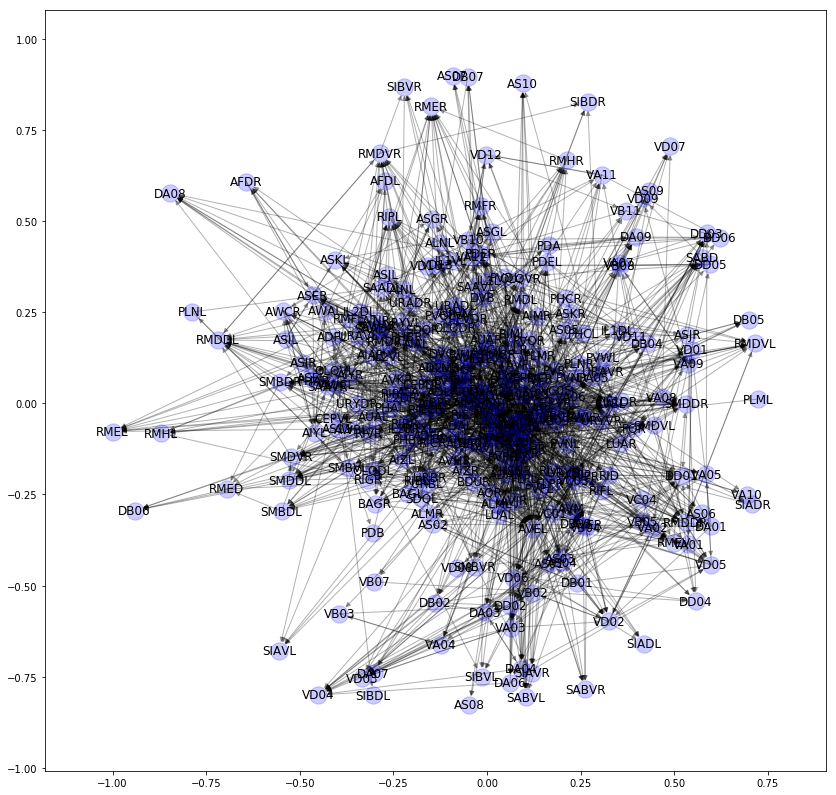

In [3]:
# Build plot
plt.figure(figsize=(14,14))
edge_expansion=12
node_expansion=30
layout = nx.spring_layout(G, weight=None, k=0.4)
#weights=nx.get_edge_attributes(G,'weight')
_=nx.draw_networkx_edges(G,pos=layout, alpha=0.3)
#                      width=[weights[i]*edge_expansion for i in G.edges],)
_=nx.draw_networkx_nodes(G,pos=layout, node_color='blue', alpha=0.2, )
#                       node_size=[G.out_degree[i]*node_expansion for i in G.nodes]*node_expansion)
_=nx.draw_networkx_labels(G,pos=layout)

Below is the binary adjacency matrix.  Note the asymmetry due to directionality.  Also note that nodes are ordered alphabetically here, and the connection patterns are likely due to connectivity of similarly-named neurons.

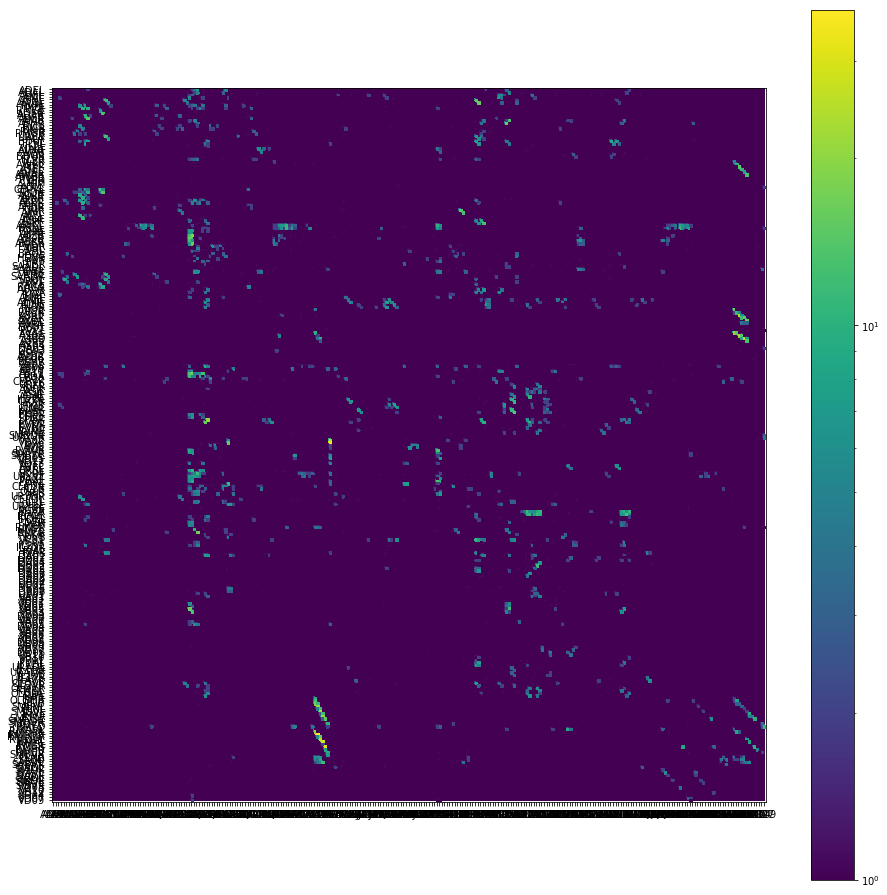

In [20]:
plot_adjmtx(G, True, node_order=node_list)

# Too Many Cycles
I first tried to search for all cycles by brute force, but this filled up my hard drive and crashed after identifying over 6 million cycles (over 11 gigabytes of cycles with no compression).  This meant analysis of cycles individually would be intractable for me.

In [ ]:
raise NotImplementedError  # This cell is not meant to be run!
with open('cycles.txt','a') as f:
    f.write('cycles = [\n')
    i = 0
    for c in nx.simple_cycles(G):
        line = '{},'.format(repr(c).replace(' ',''))
        f.write(line)
        i += 1
        if i % 1e5 == 0:
            print('Found {} cycles'.format(i))
        f.write(']\n\n\n')

# Clustering

### Girvan-Newman Clustering
My first test of clustering the graph used Girvan-Newman clustering to find communities.  This didn't work super well as a clustering method because the majority of the first clusters it found were single-node clusters.  However, this alone was interesting, and raised an interesting question: how is it that the edges out of a single node can have the highest betweenness centrality even when most of the edges connecting it have been removed?  I put this question on the back burner.

In [ ]:
gn_clusters_gen = community.centrality.girvan_newman(G)
gn_clusters = None
for i in range(15):
    gn_clusters = next(gn_clusters_gen)
    print('Iteration {} yielded communities of sizes {}'.format(i+1, [len(c) for c in gn_clusters]))

In [ ]:
cluster_nodes = []
for c in gn_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
cluster_nodes.sort(key=len, reverse=True)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

### Label Propagation Clustering
I tried Label Propagation Clustering, but it did not terminate after an hour of computation.

In [ ]:
lpa_clusters = community.label_propagation.asyn_lpa_communities(G)
Gc = nx.DiGraph()
cluster_nodes = []
for c in mod_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

### Greedy Modularity Clustering
Next, I tried greedy modularity clustering, which identified 12 communities, the largest of which contained 41 nodes.  Only one cluster had just a single node.  I felt this would be adequate as a starting point.

In [ ]:
mod_clusters = community.modularity_max.greedy_modularity_communities(G)
Gc = nx.DiGraph()
cluster_nodes = []
for c in mod_clusters:
    sub = G.subgraph(c)
    cluster_nodes.append(sub)
    Gc = nx.compose(Gc, sub)
print('Cluster sizes: {}'.format([len(c) for c in cluster_nodes]))

### K-means Clustering
Finally, I tried K-means clustering and decided to stick with it because of the relatively even distribution of cluster sizes.  The code below tries K-means across a range of values of $k$.  I settled on using $k=9$ because of sizes of each cluster (maximum size less than 1/3 of overall nodes, and minimum size greater than 2).

In [5]:
def compute_k_means(num_clusters):
    clustergen = cluster.KMeans(n_clusters=num_clusters, n_init=300)
    edge_mat = graph_to_edge_matrix(Gu)
    k_clusters_fit = clustergen.fit(edge_mat)
    k_clusters = list(k_clusters_fit.labels_)
    # Generate cluster node lists
    cluster_nodes = [list() for i in range(num_clusters)]
    for i in range(len(k_clusters)):
        cluster_nodes[ k_clusters[i] ].append(node_list[i])
    cluster_nodes.sort(key=len, reverse=True)
    print('Cluster sizes (k={}): {}'.format(num_clusters, [len(c) for c in cluster_nodes]))
    return cluster_nodes

for k in range(5, 15):
    compute_k_means(k)
print('\nFinal chosen cluster:')
cluster_nodes = compute_k_means(9)
print('Final clusters:\n{}'.format(cluster_nodes))

Cluster sizes (k=5): [125, 87, 37, 19, 11]
Cluster sizes (k=6): [124, 61, 54, 17, 14, 9]
Cluster sizes (k=7): [111, 60, 54, 19, 16, 12, 7]
Cluster sizes (k=8): [105, 61, 30, 21, 19, 17, 15, 11]
Cluster sizes (k=9): [97, 58, 30, 24, 19, 16, 13, 11, 11]
Cluster sizes (k=10): [105, 47, 28, 26, 20, 18, 13, 12, 8, 2]
Cluster sizes (k=11): [121, 58, 39, 16, 14, 12, 8, 5, 2, 2, 2]
Cluster sizes (k=12): [102, 30, 30, 24, 24, 16, 16, 15, 13, 5, 2, 2]
Cluster sizes (k=13): [103, 35, 30, 24, 19, 14, 12, 11, 11, 8, 6, 4, 2]
Cluster sizes (k=14): [93, 44, 38, 31, 19, 15, 14, 13, 3, 2, 2, 2, 2, 1]

Final chosen cluster:
Cluster sizes (k=9): [80, 60, 28, 27, 23, 21, 16, 14, 10]
Final clusters:
[['ADFL', 'ADFR', 'AFDL', 'AFDR', 'AINL', 'AIYR', 'ALA', 'ALML', 'ALMR', 'ALNL', 'ALNR', 'ASGR', 'ASJL', 'ASJR', 'ASKR', 'AUAR', 'AWAL', 'AWAR', 'AWBL', 'AWBR', 'BAGL', 'BDUL', 'BDUR', 'DB04', 'DB07', 'DD04', 'DD05', 'DD06', 'DVB', 'PDA', 'PDB', 'PHAL', 'PHAR', 'PHCR', 'PLML', 'PLNL', 'PLNR', 'PVM', 'PVQL', 'PV

In [4]:
# Force-set this so it remains consistent (k-means returns different results due to random seeds)
cluster_nodes = [['ADFL', 'ADFR', 'AFDL', 'AFDR', 'AINL', 'AIYR', 'ALA', 'ALML', 'ALMR', 'ALNL', 'ALNR', 'ASGR', 'ASJL', 'ASJR', 'ASKR', 'AUAR', 'AWAL', 'AWAR', 'AWBL', 'AWBR', 'BAGL', 'BDUL', 'BDUR', 'DB04', 'DB07', 'DD04', 'DD05', 'DD06', 'DVB', 'PDA', 'PDB', 'PHAL', 'PHAR', 'PHCR', 'PLML', 'PLNL', 'PLNR', 'PVM', 'PVQL', 'PVWL', 'RID', 'RIGL', 'RIR', 'RMED', 'RMHL', 'SAAVR', 'SABVR', 'SIADL', 'SIADR', 'SIAVL', 'SIAVR', 'SIBDL', 'SIBDR', 'SIBVL', 'SIBVR', 'SMBDL', 'SMBDR', 'SMBVL', 'SMBVR', 'URYDR', 'VA01', 'VA07', 'VB01', 'VB03', 'VB04', 'VB05', 'VB06', 'VB07', 'VB08', 'VB09', 'VB10', 'VB11', 'VC04', 'VC05', 'VD07', 'VD08', 'VD09', 'VD10', 'VD11', 'VD12'], ['ADER', 'AQR', 'AS01', 'AS02', 'AS03', 'AS04', 'AS05', 'AS06', 'AS07', 'AS08', 'AS09', 'AS10', 'AS11', 'AUAL', 'AVM', 'DA01', 'DA02', 'DA03', 'DA04', 'DA05', 'DA06', 'DA07', 'DA08', 'DA09', 'DB02', 'DB03', 'DB05', 'DB06', 'DVA', 'FLPL', 'FLPR', 'LUAL', 'LUAR', 'PDEL', 'PDER', 'PHBL', 'PHBR', 'PHCL', 'PLMR', 'PQR', 'PVDL', 'PVDR', 'PVPL', 'PVR', 'PVWR', 'SABD', 'SABVL', 'SDQL', 'SDQR', 'VA02', 'VA03', 'VA04', 'VA05', 'VA06', 'VA08', 'VA09', 'VA10', 'VA11', 'VA12', 'VD13'], ['CEPDR', 'CEPVR', 'IL1DR', 'IL1R', 'IL1VR', 'IL2DR', 'IL2L', 'IL2R', 'IL2VL', 'IL2VR', 'OLLR', 'OLQDR', 'OLQVR', 'RIAR', 'RICR', 'RIH', 'RIPR', 'RIVL', 'RMDVR', 'RMEL', 'RMER', 'RMEV', 'RMHR', 'URADR', 'URAVL', 'URAVR', 'URBR', 'URXR'], ['ADEL', 'BAGR', 'CEPDL', 'CEPVL', 'IL1DL', 'IL1L', 'IL1VL', 'IL2DL', 'OLLL', 'OLQDL', 'OLQVL', 'RIAL', 'RIBL', 'RIPL', 'RIVR', 'RMDDL', 'RMDDR', 'RMDVL', 'RMGL', 'SMDVL', 'SMDVR', 'URADL', 'URBL', 'URXL', 'URYDL', 'URYVL', 'URYVR'], ['ADAL', 'ADLL', 'ADLR', 'AIML', 'AIMR', 'ASHR', 'AVFL', 'AVFR', 'AVG', 'AVHL', 'AVHR', 'AVJL', 'AVJR', 'AVL', 'HSNL', 'HSNR', 'PVNL', 'PVNR', 'PVPR', 'PVQR', 'RIFL', 'RIFR', 'RMGR'], ['ADAR', 'AIZR', 'AVKL', 'AVKR', 'DVC', 'PVT', 'RIBR', 'RICL', 'RIGR', 'RIML', 'RIMR', 'RIS', 'RMDL', 'RMDR', 'RMFL', 'RMFR', 'SAADL', 'SAADR', 'SAAVL', 'SMDDL', 'SMDDR'], ['AIAL', 'AIAR', 'AIBL', 'AIBR', 'AINR', 'AIYL', 'AIZL', 'ASEL', 'ASER', 'ASGL', 'ASHL', 'ASIL', 'ASIR', 'ASKL', 'AWCL', 'AWCR'], ['DB01', 'DD01', 'DD02', 'DD03', 'VB02', 'VC01', 'VC02', 'VC03', 'VD01', 'VD02', 'VD03', 'VD04', 'VD05', 'VD06'], ['AVAL', 'AVAR', 'AVBL', 'AVBR', 'AVDL', 'AVDR', 'AVEL', 'AVER', 'PVCL', 'PVCR']]


### Cluster Visualizations
Below is the full graph's connectivity matrix again, this time sorted by clusters.  This was quite surprising, as the smaller clusters tended to be more connected within themselves than the larger clusters, where connections were highly spread.  In particular, the largest cluster seemed to hardly be self-connected at all, making it seem like the cluster where neurons that don't fit into a particular cluster go.

Another interesting observation was directly related to feedback loops.  The second-largest cluster was highly connected to the smallest cluster, but in a peculiar way.  Neurons in the second cluster that were pre-synaptic to the smallest cluster tended not to be post-synaptic to the smallest cluster, whereas the reverse was also true.  This suggests that there are a number of feedback loops between these two clusters.

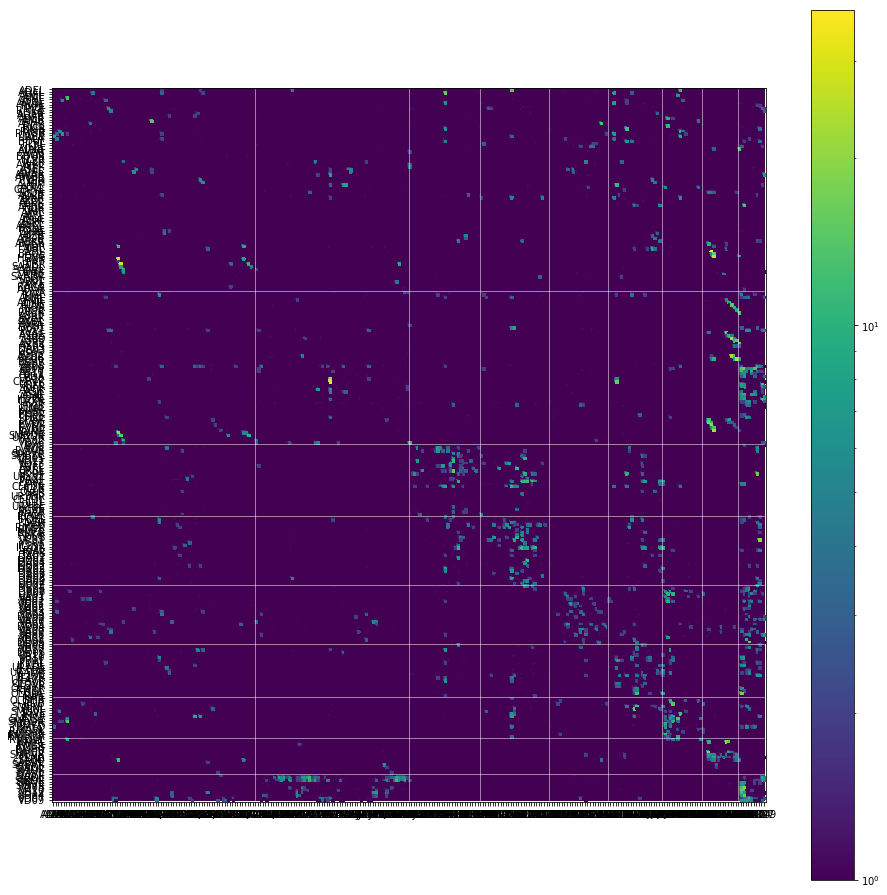

In [6]:
node_order = []
lines = []
for c in cluster_nodes:
    node_order += c
    lines.append(len(node_order)-1)
del lines[-1]
plot_adjmtx(G, True, node_order, lines)

Now that I've settled on a clustering, I generate subgraphs of each cluster.

In [7]:
# Build subgraphs
cluster_subgraphs = []
for c in cluster_nodes:
    sub = G.subgraph(c)
    cluster_subgraphs.append(sub)
# Build a map which associates each node name with its cluster number
node_cluster_map = {}
for cluster in range(len(cluster_nodes)):
    for node in cluster_nodes[cluster]:
        node_cluster_map[node] = cluster

# Clusters to Graph
Given a clustering, I wanted to see what the connectivity between those clusters looked like.  For my first test, I simply included an unweighted directed edge between two clusters if there was a single edge of that direction between two nodes within those clusters.  This turned out to be rather useless, as there was a bidirectional connection between most pairs of clusters.

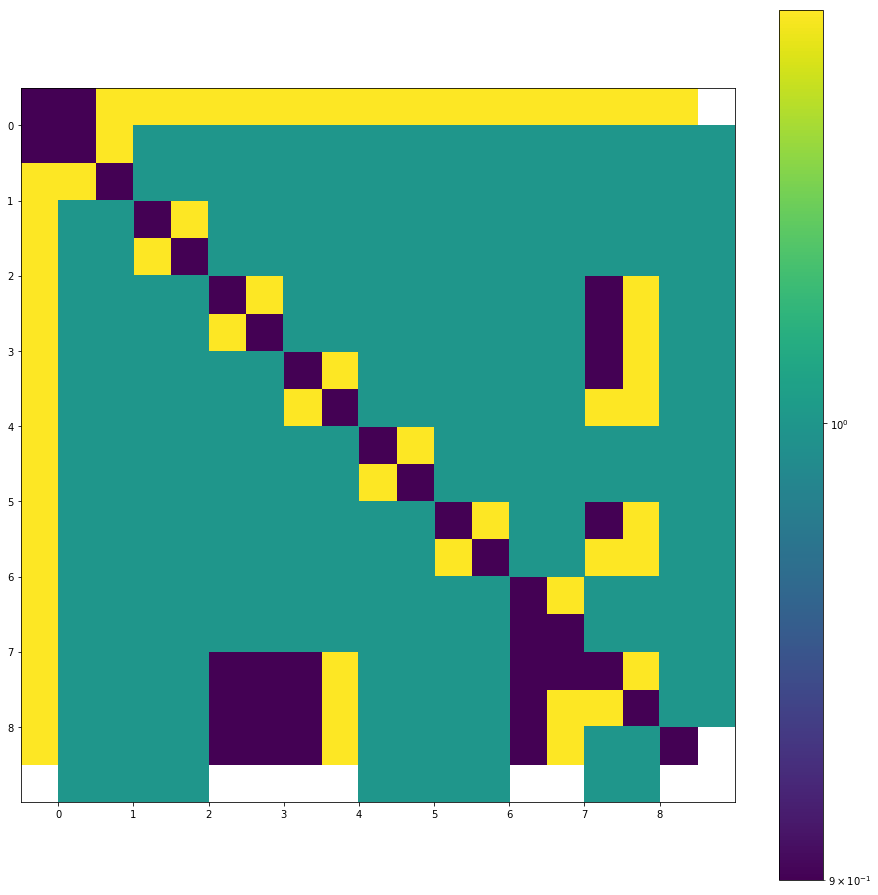

In [33]:
# Build a cluster lookup map indexed by node name
node_cluster_map = get_node_cluster_map(cluster_nodes)
C = nx.DiGraph()
for i in range(len(cluster_nodes)):
    C.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        C.add_edge(from_cluster, to_cluster)
plot_adjmtx(C)

This isn't particularly useful: every cluster has a bidirectional connection to almost every other.  I then tried weighting these connections by the number of connections between them.  This was interesting, as it revealed that the majority of possible cluster-to-cluster edges were instantiated by only a few edges in the full graph, whereas some connections were duplicated nearly 100 times.

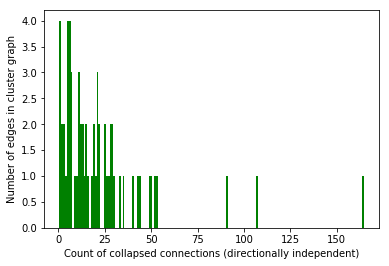

In [34]:
node_cluster_map = get_node_cluster_map(cluster_nodes)
Cw = nx.DiGraph()
for i in range(len(cluster_nodes)):
    Cw.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        existing_edge = Cw.get_edge_data(from_cluster, to_cluster)
        if existing_edge is None:
            Cw.add_edge(from_cluster, to_cluster, weight=1)
        else:
            new_weight = existing_edge['weight'] + 1
            Cw[from_cluster][to_cluster]['weight'] = new_weight

weight_hist = get_weight_histogram(Cw)
width = 1.0     
plt.bar(weight_hist.keys(), weight_hist.values(), width, color='g')
plt.xlabel('Count of collapsed connections (directionally independent)')
plt.ylabel('Number of edges in cluster graph')
plt.show()

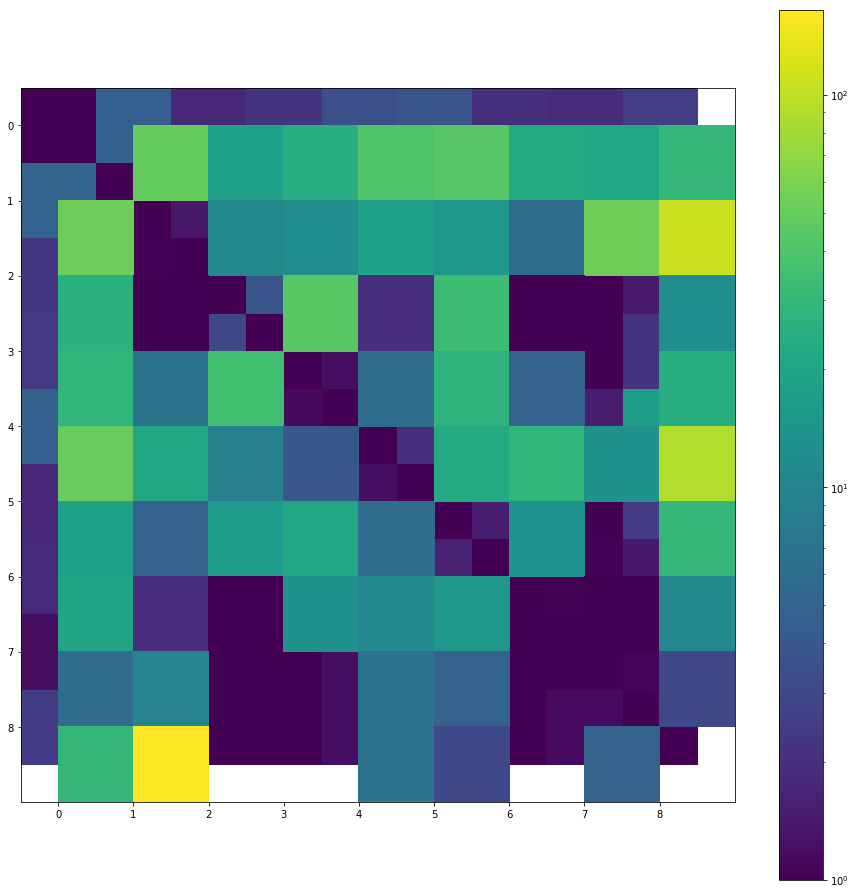

In [35]:
plot_adjmtx(Cw)

Quite interesting: most connections between clusters are weak, but there are some strongly connected outliers.  Let's see what happens if, for each edge, the direction and weight are determined by the difference between connections going each direction.

In [ ]:
node_cluster_map = get_node_cluster_map(cluster_nodes)
C = nx.DiGraph()
for i in range(len(cluster_nodes)):
    C.add_node(i)
for edge in list(G.edges):
    from_cluster = node_cluster_map[edge[0]]
    to_cluster = node_cluster_map[edge[1]]
    if from_cluster != to_cluster:
        existing_edge = C.get_edge_data(from_cluster, to_cluster)
        if existing_edge is None:
            C.add_edge(from_cluster, to_cluster, weight=1)
        else:
            new_weight = existing_edge['weight'] + 1
            C[from_cluster][to_cluster]['weight'] = new_weight

weight_hist = get_weight_histogram(C)
width = 1.0     
plt.bar(weight_hist.keys(), weight_hist.values(), width, color='g')
plt.show()

# Community Subgraphs

In [8]:
cycle_counts = []
for sub in range(len(cluster_subgraphs)):
    cycle_counts.append(count_cycles(cluster_subgraphs[sub]))
    print('Cluster {} has: {} nodes, {} cycles'.format(sub, len(cluster_subgraphs[sub]),
                                                       cycle_counts[sub]))

Cluster 0 has: 80 nodes, 43 cycles
Cluster 1 has: 60 nodes, 23 cycles
Cluster 2 has: 28 nodes, 436 cycles
Cluster 3 has: 27 nodes, 234 cycles
Cluster 4 has: 23 nodes, 2726948 cycles
Cluster 5 has: 21 nodes, 19848 cycles
Cluster 6 has: 16 nodes, 1452 cycles
Cluster 7 has: 14 nodes, 34 cycles
Cluster 8 has: 10 nodes, 6140 cycles


The larger subgraphs have too many cycles to be useful.  Let's examine only subgraphs indexed 6 through 10.

In [ ]:
def analyze_subgraph(g):
    cycles = []
    for c in nx.simple_cycles(g):
        x = {
            'nodes':c,
            'ct':len(c),
        }
        cycles.append(x)
    len_hist = get_cycle_length_histogram(cycles)
    width = 1.0     
    plt.bar(len_hist.keys(), len_hist.values(), width, color='g')
    plt.xlabel('Count of collapsed connections (directionally independent)')
    plt.ylabel('Number of edges in cluster graph')
    plt.show()

analyze_subgraph(cluster_subgraphs[4])

### Cycle Count Normalization
To normalize cycle counts against possible counts, I needed to compute the total number of cycles possible in each group.  I considered both formulas on [this StackExchange question](https://math.stackexchange.com/questions/1363963/number-of-cycles-in-complete-graph), and settled on B2C's equation, which assumes the graph is complete and then counts every subset of 2 or more nodes:

$C_{total} = \sum_{i=2}^k \binom{k}{i} $ where $k=$ the number of nodes.

This revealed an interesting observation, which is that iterations in the middle of the range yielded many more cycles of medium length than cycles of small and large length (the binomial function returns its largest values when $i$ is near the middle of its range, and tails out such that $\binom{k}{0}=1$ and $\binom{k}{k}=1$).  This might explain the shape of cycle length histograms in each subgraph.

In [19]:
from math import factorial
def max_cycles(k):
    sumval = 0
    for i in range(2,k+1):
        sumval += factorial(k) // (factorial(k-i) * factorial(i))
    return sumval

cycle_utilization = []
for sub in range(len(cycle_counts)):
    cycle_utilization.append( float(cycle_counts[sub]) / max_cycles(len(cluster_subgraphs[sub])) )
print(cycle_utilization)

[3.556876633978019e-23, 1.9949319973733282e-17, 1.6242267456001626e-06, 1.7434362233893145e-06, 0.325078463778869, 0.009464363201136791, 0.022161510401562907, 0.002077096951554768, 6.061204343534057]


# Rich Club Cycles


In [ ]:
cutoff=50
G_highdegree=G.copy()
deg = dict(G_highdegree.degree())
to_remove = [n for n in deg if deg[n] <= cutoff]
G_highdegree.remove_nodes_from(to_remove)
print('RC has {} nodes with cutoff {}'.format(len(G_highdegree.nodes),cutoff))
nx.draw_spring(G_highdegree, with_labels=True)

In [1]:
analyze_subgraph(G_highdegree)

NameError: name 'analyze_subgraph' is not defined